In [1]:
import netCDF4 as nc
import scipy.io as sio
import os,sys,fnmatch,time
from scipy import interpolate
import numpy as np
import numpy.ma as ma
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import cmocean as cmo

from salishsea_tools.nc_tools import scDataset
from salishsea_tools import geo_tools

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/home/imachuca/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
data = sio.loadmat('../observations/MackenzieTransects.mat')

struct_north = data['stn']
struct_south = data['sts']
struct_axis = data['ax']
struct_slope = data['cs']

dtype_north = struct_north.dtype
dtype_south = struct_south.dtype
dtype_axis = struct_axis.dtype
dtype_slope = struct_slope.dtype

data_north = {n: struct_north[n][0, 0] for n in dtype_north.names}
data_south = {n: struct_south[n][0, 0] for n in dtype_south.names}
data_axis = {n: struct_axis[n][0, 0] for n in dtype_axis.names}
data_slope = {n: struct_slope[n][0, 0] for n in dtype_slope.names}

#
obs_lat_s = data_south['lat_adcp'][0,:]
obs_lon_s = data_south['lon_adcp'][0,:]
obs_z_s = data_south['z_adcp'][1:, 0]
obs_u_s = data_south['u'][1:]
obs_v_s = data_south['v'][1:]

obs_lat75_s = data_south['lat75_adcp'][:, 0]
obs_lon75_s = data_south['lon75_adcp'][:, 0]
obs_z75_s = data_south['z75_adcp'][1:, 0]
obs_u75_s = data_south['u75'][1:, :]
obs_v75_s = data_south['v75'][1:, :]

#
obs_lat_n = data_north['lat_adcp'][0,:]
obs_lon_n = data_north['lon_adcp'][0,:]
obs_z_n = data_north['z_adcp'][1:, 0]
obs_u_n = data_north['u'][1:]
obs_v_n = data_north['v'][1:]

obs_lat75_n = data_north['lat75_adcp'][:, 0]
obs_lon75_n = data_north['lon75_adcp'][:, 0]
obs_z75_n = data_north['z75_adcp'][1:, 0]
obs_u75_n = data_north['u75'][1:, :]
obs_v75_n = data_north['v75'][1:, :]

#
obs_lat_p = data_slope['lat_adcp'][0,:]
obs_lon_p = data_slope['lon_adcp'][0,:]
obs_z_p = data_slope['z_adcp'][1:, 0]
obs_u_p = data_slope['u'][1:]
obs_v_p = data_slope['v'][1:]

obs_lat75_p = data_slope['lat75_adcp'][:, 0]
obs_lon75_p = data_slope['lon75_adcp'][:, 0]
obs_z75_p = data_slope['z75_adcp'][1:, 0]
obs_u75_p = data_slope['u75'][1:, :]
obs_v75_p = data_slope['v75'][1:, :]

In [3]:
all_z_n = np.array(sorted(np.concatenate((obs_z_n, obs_z75_n))))
all_z_s = np.array(sorted(np.concatenate((obs_z_s, obs_z75_s))))
all_z_p = np.array(sorted(np.concatenate((obs_z_p, obs_z75_p))))
all_z = all_z_n #they're all the same
all_z

array([ 13.13395265,  16.89272313,  20.65149362,  24.4102641 ,
        28.16903458,  31.92780507,  35.68657555,  39.44534603,
        43.20411652,  44.        ,  46.962887  ,  50.72165748,
        54.        ,  54.48042797,  58.23919845,  61.99796893,
        64.        ,  65.75673941,  69.5155099 ,  73.27428038,
        74.        ,  77.03305086,  80.79182135,  84.        ,
        84.55059183,  88.30936231,  92.0681328 ,  94.        ,
        95.82690328,  99.58567376, 103.34444425, 104.        ,
       114.        , 124.        , 134.        , 144.        ,
       154.        , 164.        , 174.        , 184.        ,
       194.        , 204.        , 214.        , 224.        ,
       234.        , 244.        , 254.        , 264.        ,
       274.        , 284.        , 294.        , 304.        ,
       314.        , 324.        , 334.        , 344.        ,
       354.        , 364.        , 374.        , 384.        ,
       394.        , 404.        , 414.        , 424.  

In [4]:
def get_vels(dirname, fname, meshmaskname, time_s, time_f):
    
    filesU = general_functions.get_files(dirname, fname, 'grid_U') 
    filesV = general_functions.get_files(dirname, fname, 'grid_V') 
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(filesU) as dsU, scDataset(filesV) as dsV:
        uvel0 = dsU.variables['vozocrtx'][time_s:time_f,:,y,x]
        depth = dsU.variables['depthu'][:]
        nav_lat = dsU.variables['nav_lat'][y, x]
        nav_lon = dsU.variables['nav_lon'][y, x]
        vvel0 = dsV.variables['vomecrty'][time_s:time_f,:,y,x]
        
    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,:,y,x]
        vmask0 = dsM.variables['vmask'][0,:,y,x]

    umask = np.tile(umask0, (uvel0.shape[0], 1, 1, 1))
    vmask = np.tile(vmask0, (vvel0.shape[0], 1, 1, 1))

    uvel = np.ma.array(uvel0, mask=1 - umask)
    vvel = np.ma.array(vvel0, mask=1 - vmask)
    
    return uvel, umask, vvel, depth, nav_lon, nav_lat

In [5]:
def get_speeds(U_vel, V_vel, nav_lon, nav_lat, arrow):
    ugrid = U_vel[:]
    vgrid = V_vel[:]
    u_nstg0 = (np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2)[..., 1:, :]
    v_nstg0 = (np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2)[..., 1:]
    u_nstg = u_nstg0[::arrow,::arrow]
    v_nstg = v_nstg0[::arrow,::arrow]
    x_slice = nav_lon[::arrow,::arrow]
    y_slice = nav_lat[::arrow,::arrow]
    speeds = np.sqrt(u_nstg**2 + v_nstg**2)
    return x_slice, y_slice, u_nstg, v_nstg, speeds

def get_speeds_o(U_vel, V_vel, lon_o, lat_o, arrow):
    ugrid = U_vel[:]
    vgrid = V_vel[:]
    u_nstg0 = (np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2)[:]
    v_nstg0 = (np.add(vgrid[...,:-1], vgrid[...,1:]) / 2)[:]
    u_nstg = u_nstg0[::arrow]
    v_nstg = v_nstg0[::arrow]
    x_slice = lon_o[::arrow]
    y_slice = lat_o[::arrow]
    speeds = np.sqrt(u_nstg**2 + v_nstg**2)
    return x_slice, y_slice, u_nstg, v_nstg, speeds

In [11]:
def get_data_at_depth(ax, plot_z, arrow, zo, c, cmin, cmax,
                      obs_z_0, obs_z75_0,
                      obs_lat_0, obs_lat75_0,
                      obs_lon_0, obs_lon75_0,
                      obs_u_0, obs_u75_0,
                      obs_v_0, obs_v75_0, fs_str):
    
    try:
        ind = np.where(obs_z_0 == plot_z)[0][0]
        obs_z = obs_z_0[ind]
        obs_lat = obs_lat_0
        obs_lon = obs_lon_0
        obs_u = obs_u_0[ind, :]
        obs_v = obs_v_0[ind, :]
        flag = 'adcp'

    except IndexError:
        ind = np.where(obs_z75_0 == plot_z)[0][0]
        obs_z = obs_z75_0[ind]
        obs_lat = obs_lat75_0
        obs_lon = obs_lon75_0
        obs_u = obs_u75_0[ind, :]
        obs_v = obs_v75_0[ind, :]
        flag = '75 adcp'
        
    ax.quiver(obs_lon[::arrow], obs_lat[::arrow], obs_u[::arrow], obs_v[::arrow], 
                  clim=[cmin,cmax], color=c, pivot='tail', width=0.005, headwidth=2.5, zorder=zo)
    
    ax.plot(obs_lon, obs_lat, c='k', linewidth=1, zorder=zo)
    
    ax.set_title('Depth $\sim$ ' + str(int(np.round(plot_z,1)))+' m' , fontsize=fs_str)
    
    return ax

In [12]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/real_baseAW/'
fname = '1_MCKNZ_1h_20170101_201701*'
meshmaskname = '1_mesh_mask.nc'
time_s = 24
time_f = time_s+48

uvel, umask, vvel, depth, nav_lon, nav_lat = get_vels(dirname, fname, meshmaskname, time_s, time_f)
uvel_daily = np.mean(uvel, axis=0)
vvel_daily = np.mean(vvel, axis=0)
umask_daily = np.mean(umask, axis=0)

f_u = interpolate.interp1d(depth, uvel_daily, axis=0)
f_v = interpolate.interp1d(depth, vvel_daily, axis=0)
f_m = interpolate.interp1d(depth, umask_daily, axis=0)

In [13]:
def plot_all(plot_all_z):
    
    fs_numb, fs_str = 25, 30

    fig, axes = plt.subplots(2, 1, figsize=(12, 22), sharex=True, sharey=True)
    for ax, plot_z, n in zip(axes.flatten(), plot_all_z, np.arange(2)):
        
        ax.tick_params(axis='both', which='both', length=0, labelsize=fs_numb)

        mod_u = f_u(plot_z)
        mod_v = f_v(plot_z)
        mod_mask = f_m(plot_z)

        cmap = cmo.cm.matter
        cmap.set_bad('#8b7765')
        cmin, cmax = 0, 0.2

        x_slice, y_slice, u_nstg, v_nstg, speeds = get_speeds(mod_u, mod_v, nav_lon, nav_lat, 1)
        plot_speeds = np.ma.array(speeds, mask=1 - mod_mask[1:, 1:])
        q = ax.pcolormesh(x_slice, y_slice, plot_speeds, cmap=cmap, vmin=0, vmax=1.6)
        
        #arr = 8
        arr = 5
        ax.quiver(x_slice[::arr, ::arr], y_slice[::arr, ::arr], u_nstg[::arr, ::arr], v_nstg[::arr, ::arr], 
                  clim=[cmin,cmax], color='#6497b1', pivot='mid', width=0.005, headwidth=2.5)
        
        co = '#03396c'
        arrow, zo, c = 1, 3, co
        ax = get_data_at_depth(ax, plot_z, arrow, zo, c, cmin, cmax,
                               obs_z_n, obs_z75_n, obs_lat_n, obs_lat75_n, obs_lon_n, obs_lon75_n,
                               obs_u_n, obs_u75_n, obs_v_n, obs_v75_n, fs_str)
        
        arrow, zo, c = 1, 2, co
        ax = get_data_at_depth(ax, plot_z, arrow, zo, c, cmin, cmax,
                               obs_z_s, obs_z75_s, obs_lat_s, obs_lat75_s, obs_lon_s, obs_lon75_s,
                               obs_u_s, obs_u75_s, obs_v_s, obs_v75_s, fs_str)
        
        arrow, zo, c = 1, 1, co
        ax = get_data_at_depth(ax, plot_z, arrow, zo, c, cmin, cmax,
                               obs_z_p, obs_z75_p, obs_lat_p, obs_lat75_p, obs_lon_p, obs_lon75_p,
                               obs_u_p, obs_u75_p, obs_v_p, obs_v75_p, fs_str)

        ax.set_xlim([-140.5, -136.8])
        ax.set_ylim([69.9, 70.2])
        w=1/math.cos(math.radians(70))#69.8
        ax.set_aspect(w)

    fig.tight_layout(w_pad=0.4, h_pad=0.8)
    fig.patch.set_facecolor('white') 
    fig.savefig('./fig_observations_currents.png', dpi=150, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())
    print('flow direction for hours ' + str(time_s) + '-'+ str(time_f))
    return fig

flow direction for hours 24-72


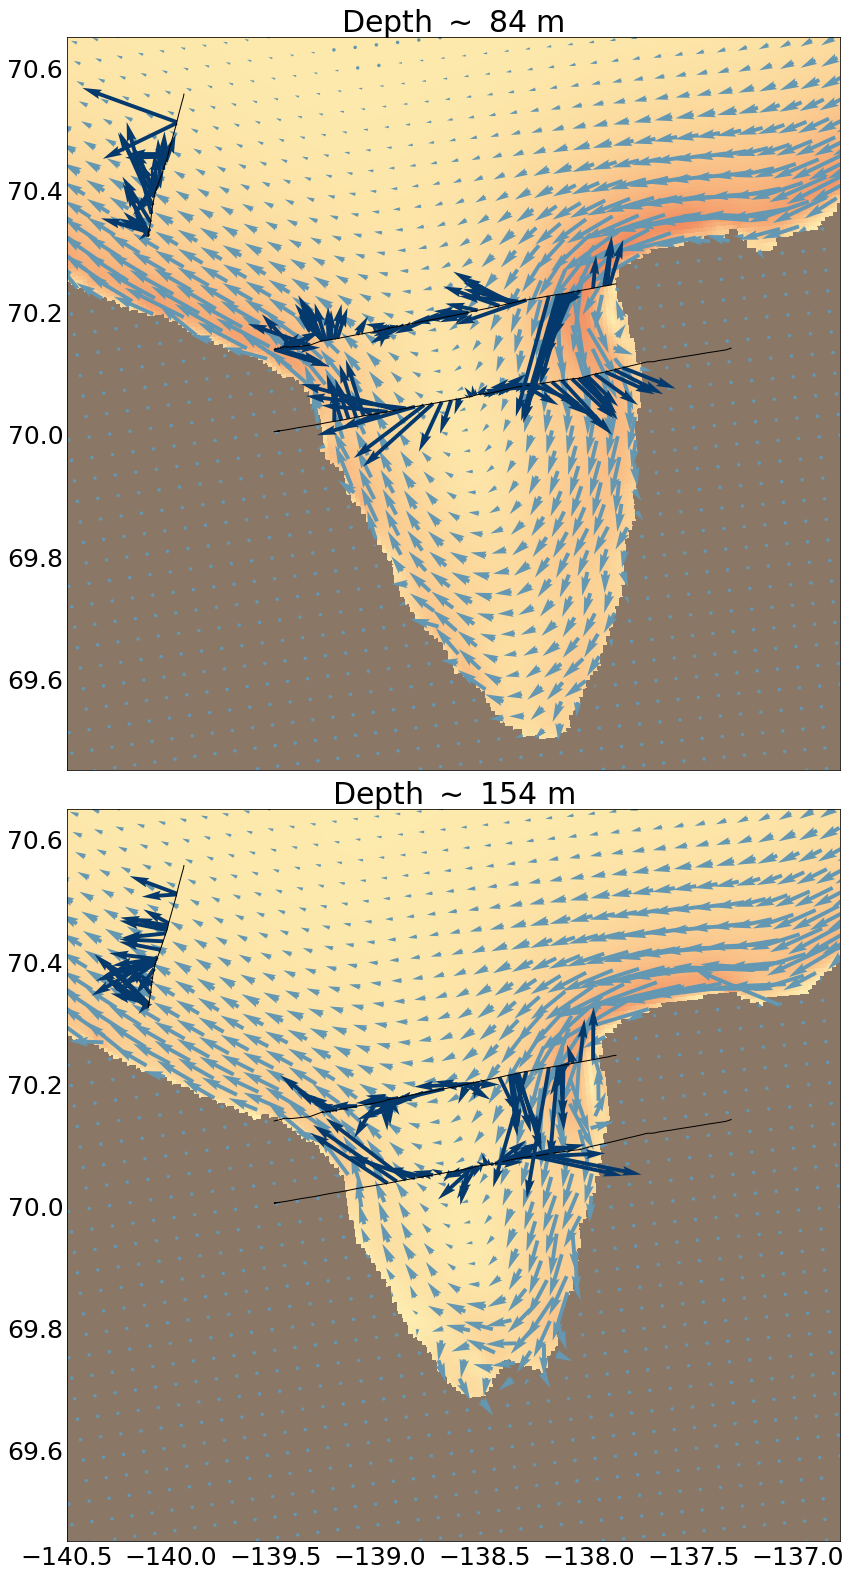

In [14]:
plot_all_z = [all_z[23], all_z[36]]
fig = plot_all(plot_all_z)